In [1]:
# This notebook does model training. We use learning curves to guide us to a reasonable choice of hyperparameters.
# Then we train a "final model" to be used for actual translation.
#
# TODO: One could explore hyperparameters in a more automated fashion, e.g. using Hyperopt.
#
#

In [2]:
!pwd

/Users/sr_old/Desktop/attention_seq2seq


In [3]:
import sys
print(sys.executable)
print(sys.version)

/Users/sr_old/Desktop/attention_seq2seq/p3.10_attention_seq2seq/bin/python
3.10.13 (main, Aug 24 2023, 22:36:46) [Clang 14.0.3 (clang-1403.0.22.14.1)]


In [4]:
colab = False

if colab:
    from google.colab import drive
    drive.mount("/content/gdrive")

## Imports

In [5]:
import math
import re

In [6]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
#from torchviz import make_dot
from torch.utils.data import Dataset, DataLoader #, TensorDataset
from torch.utils.data.dataset import random_split
import datetime

In [7]:
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

In [8]:
from torch.distributions.categorical import Categorical

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline    
from matplotlib.pyplot import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = 5,5

In [10]:
import itertools
import random

In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
import pickle

In [13]:
from dataprep_functions import LanguageDataset

In [14]:
from model_functions import *

## Device and seed

In [15]:
device = 'cuda' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else 'cpu'

device

'mps'

In [16]:
seed = 42

In [17]:
torch.manual_seed(seed)
#rng = np.random.default_rng(seed)
random.seed(seed)

## Variables

In [18]:
if colab:
  path = "/content/gdrive/MyDrive/attention_seq2seq/datasets"
  results_path = "results"

else:
    # Name of the folder where data is accessed and saved
    path = "datasets"
    # Name of the folder for training results
    results_path = "results"

In [19]:
PAD_token = 0
SOS_token = 1
EOS_token = 2

## Loading the data we need

In [20]:
# Unpickling
with open(path + "/input_lang.txt", "rb") as y:
    input_lang = pickle.load(y)
with open(path + "/output_lang.txt", "rb") as y:
    output_lang = pickle.load(y)

In [21]:
# This is a small dataset, useful for debugging.
trial_dataset1 = torch.load(path + '/trial1.pt', weights_only=False)
trial_dataset2 = torch.load(path + '/trial2.pt', weights_only=False)

In [22]:
trial_dataset1[1:5]

((tensor([[ 10,   7, 154, 357],
          [117,   4,  50,  88],
          [  3,   2, 646,   9],
          [ 62,   0, 450,   2],
          [  6,   0,   6,   0],
          [  2,   0,   2,   0]]),
  [6, 3, 6, 4]),
 (tensor([[113,  24,  92, 162],
          [611,  60, 178, 430],
          [194,   6, 701,  42],
          [ 76,   2, 410, 191],
          [  4,   0,   4,   8],
          [  2,   0,   2,   2]]),
  [6, 4, 6, 6]))

In [23]:
train_dataset = torch.load(path + '/train.pt', weights_only=False)
val_dataset = torch.load(path + '/val.pt', weights_only=False)

In [24]:
len(train_dataset)

5159

## Checking the model works

In [25]:
m = Luong_full(vocab = input_lang.n_words, h_size = 2, dropout = 0, n_layers = 2, 
                    att_method = 'dot', vocab_out = output_lang.n_words, device = device)
m.to(device)

Luong_full(
  (encoder): EncoderRNN(
    (embedding): Embedding(655, 2)
    (gru): GRU(2, 1, num_layers=2, bidirectional=True)
  )
  (decoder): LuongDecoder(
    (embedding): Embedding(705, 2)
    (gru): GRU(2, 2, num_layers=2)
    (joinerFF): Linear(in_features=4, out_features=2, bias=True)
    (projFF): Linear(in_features=2, out_features=705, bias=True)
    (dropout_layer): Dropout(p=0, inplace=False)
    (alignment_vector): Attn()
  )
)

## Now train

In [26]:
# Parameter definitions:
#
#       lrate - learning rate
#
#       ratio - we set the decoder learning rate to lrate*ratio
#
#       bsize*acc_steps - this multiple gives the true batch size; acc_steps is the number of gradient accumulation steps done at training
#
#       bsize_eval - the batch size used when evaluating the model at the end of an epoch (train and val losses)
#
#       patience - regulates early stopping
#
#       h_size - this regulates the dimensionality of the neural nets used
#
#       dropout - we haev inserted dropout in multiple places
#
#       n_layers - the number of layers in the encoder and decoder GRUs
#
#       att_method - one of ['dot', 'general', 'concat']
#
#       c - a string to be added in the saved files' filename
#

07:06:20  Starting epoch 0
07:07:03  Calculating figures
07:07:19  Ending epoch 0    train_loss: 3.32   val_loss: 3.34
07:07:19  Starting epoch 1
07:08:04  Calculating figures
07:08:23  Ending epoch 1    train_loss: 2.92   val_loss: 2.98
07:08:23  Starting epoch 2
07:09:08  Calculating figures
07:09:28  Ending epoch 2    train_loss: 2.69   val_loss: 2.76
07:09:28  Starting epoch 3
07:10:15  Calculating figures
07:10:37  Ending epoch 3    train_loss: 2.49   val_loss: 2.63
07:10:37  Starting epoch 4
07:11:25  Calculating figures
07:11:48  Ending epoch 4    train_loss: 2.39   val_loss: 2.53
07:11:48  Starting epoch 5
07:12:38  Calculating figures
07:13:02  Ending epoch 5    train_loss: 2.3   val_loss: 2.49
07:13:02  Starting epoch 6
07:13:52  Calculating figures
07:14:18  Ending epoch 6    train_loss: 2.21   val_loss: 2.41
07:14:18  Starting epoch 7
07:15:10  Calculating figures
07:15:37  Ending epoch 7    train_loss: 2.13   val_loss: 2.36

best training_loss = 2.1345, best validation_los

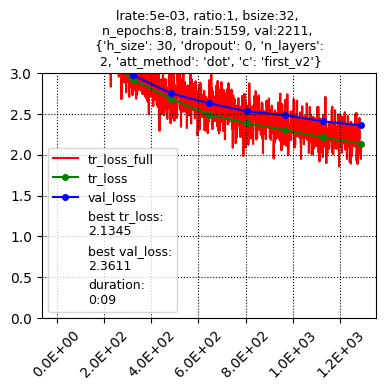

In [26]:
# 
outputs = run_model(train_dataset, val_dataset, Luong_full, lossmaker1, device= device, 
              lrate = 5e-3, ratio = 1, bsize = 16, acc_steps = 2, 
                                                    bsize_eval = 16, epochs = 8, patience = 2,
                    save = True, path = results_path, 
                  # the below are passed to the model class
                vocab = input_lang.n_words, h_size = 30, dropout = 0, n_layers = 2, 
                    att_method = 'dot', vocab_out = output_lang.n_words,
                    c = "first_v2"  
              )

Count: 1
19:37:38  Starting epoch 0
19:38:23  Calculating figures
19:38:35  Ending epoch 0    train_loss: 3.05   val_loss: 3.08
19:38:35  Starting epoch 1
19:39:21  Calculating figures
19:39:33  Ending epoch 1    train_loss: 2.67   val_loss: 2.72
19:39:33  Starting epoch 2
19:40:20  Calculating figures
19:40:33  Ending epoch 2    train_loss: 2.51   val_loss: 2.58
19:40:33  Starting epoch 3
19:41:21  Calculating figures
19:41:34  Ending epoch 3    train_loss: 2.4   val_loss: 2.5
19:41:34  Starting epoch 4
19:42:24  Calculating figures
19:42:37  Ending epoch 4    train_loss: 2.33   val_loss: 2.48
19:42:37  Starting epoch 5
19:43:27  Calculating figures
19:43:41  Ending epoch 5    train_loss: 2.26   val_loss: 2.45
19:43:41  Starting epoch 6
19:44:32  Calculating figures
19:44:45  Ending epoch 6    train_loss: 2.18   val_loss: 2.41
19:44:45  Starting epoch 7
19:45:37  Calculating figures
19:45:51  Ending epoch 7    train_loss: 2.12   val_loss: 2.35
19:45:51  Starting epoch 8
19:46:43  Calc

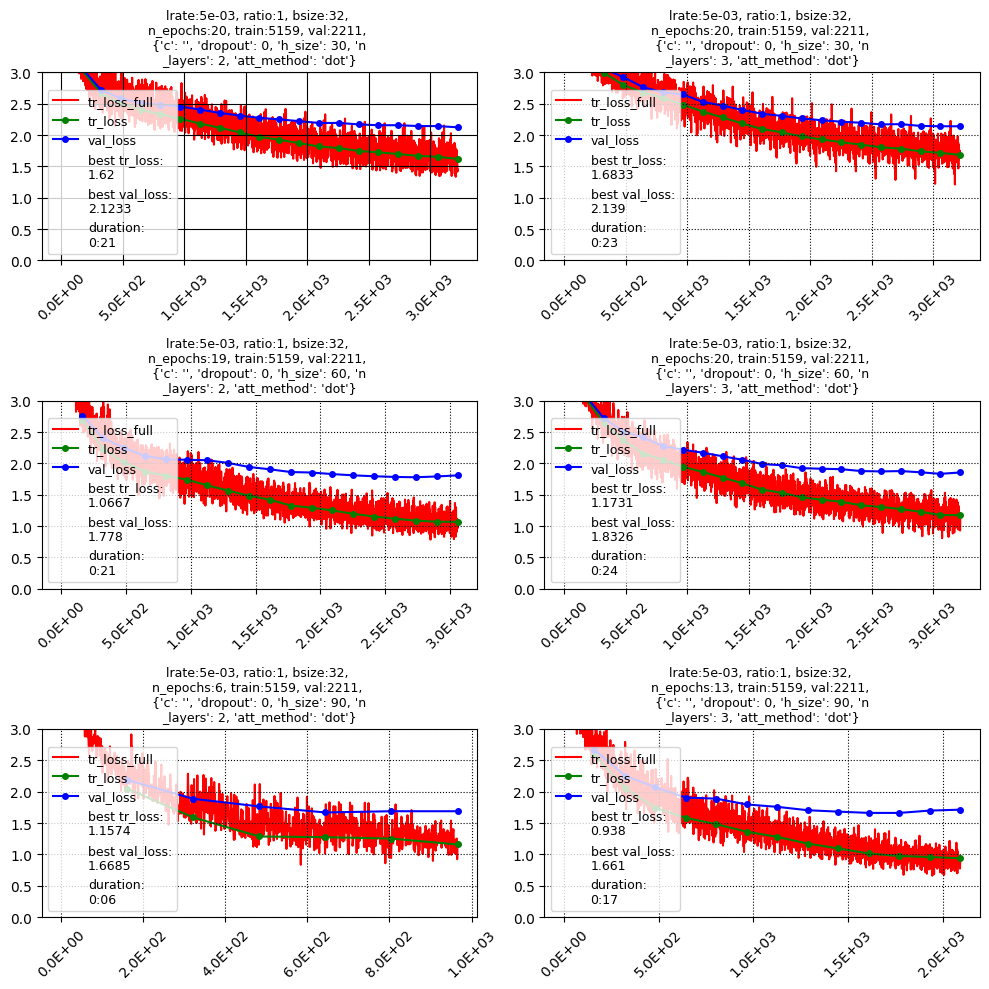

Duration: 1:53:55.798009
END ATLAS CALCULATION
Duration: 1:53:55.798081
21:31:34


In [30]:
# 

params = {     # put the longest before the shortest
    "lrate": [5e-3],   # 
    "dropout": [0],
    "ratio": [1],             
    "acc_steps": [2],          
    "bsize": [16],
    "h_size": [30, 60, 90],
    "n_layers": [2, 3],
    "att_method": ['dot']
}

keys = params.keys()
values = (params[key] for key in keys)
combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
start_time  = datetime.datetime.now()  
plt.style.use('default')
count = 1                   
rcParams['figure.figsize'] = 10,10

for i in combinations:        
        #print("Count: "+str(count))
        print("Count: "+str(count), file = terminal_output)

                    #####
        plt.subplot(3, 2, count)                                                                           
        run_model(train_dataset, val_dataset, Luong_full, lossmaker1, device = device, 
                  bsize_eval = 64 , patience = 2, epochs = 20,
                  save = True, path = results_path, atlas = True,
                  vocab = input_lang.n_words, vocab_out = output_lang.n_words, c = "",
                  **i)
        count = count+1
        print("")
        
plt.tight_layout()
plt.show()

print('Duration: {}'.format(datetime.datetime.now() - start_time))    
print("END ATLAS CALCULATION", file=terminal_output)
print('Duration: {}'.format(datetime.datetime.now() - start_time), file=terminal_output)    
print(datetime.datetime.now().strftime("%H:%M:%S"), file=terminal_output)

Count: 1
21:51:55  Starting epoch 0
21:52:45  Calculating figures
21:52:59  Ending epoch 0    train_loss: 2.12   val_loss: 2.24
21:52:59  Starting epoch 1
21:53:51  Calculating figures
21:54:05  Ending epoch 1    train_loss: 1.64   val_loss: 1.85
21:54:05  Starting epoch 2
21:54:57  Calculating figures
21:55:11  Ending epoch 2    train_loss: 1.41   val_loss: 1.78
21:55:11  Starting epoch 3
21:56:04  Calculating figures
21:56:19  Ending epoch 3    train_loss: 1.28   val_loss: 1.67
21:56:19  Starting epoch 4
21:57:14  Calculating figures
21:57:29  Ending epoch 4    train_loss: 1.16   val_loss: 1.67
21:57:29  Starting epoch 5
21:58:24  Calculating figures
21:58:40  Ending epoch 5    train_loss: 1.17   val_loss: 1.69
21:58:40  Starting epoch 6
21:59:36  Calculating figures
21:59:52  Ending epoch 6    train_loss: 1.08   val_loss: 1.65
21:59:52  Starting epoch 7
22:00:50  Calculating figures
22:01:07  Ending epoch 7    train_loss: 1.04   val_loss: 1.66
22:01:07  Starting epoch 8
22:02:04  Ca

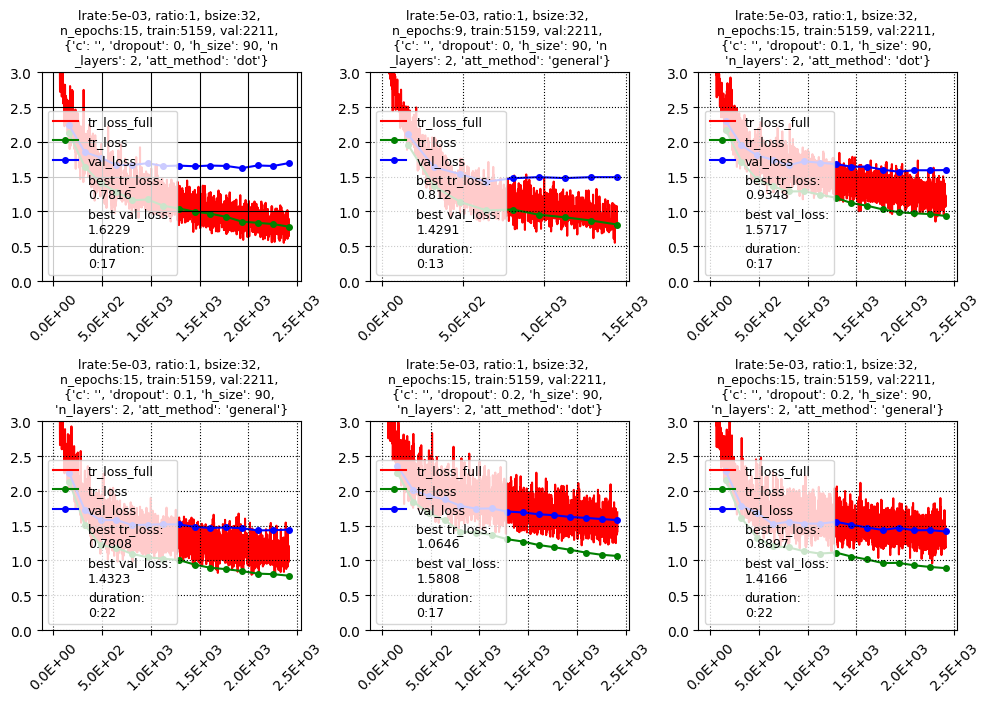

Duration: 1:50:22.670856
END ATLAS CALCULATION
Duration: 1:50:22.670910
23:42:18


In [32]:
# Better manually rename the picture saved in the folder.
# Otherwise there's a slight risk of it being over

params = {     # put the longest before the shortest
    "lrate": [5e-3],  
    "dropout": [0, 0.1, 0.2],
    "ratio": [1],             
    "acc_steps": [2],          
    "bsize": [16],
    "h_size": [90],
    "n_layers": [2],
    "att_method": ['dot', 'general']
}

keys = params.keys()
values = (params[key] for key in keys)
combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
start_time  = datetime.datetime.now()  
plt.style.use('default')
count = 1                   
rcParams['figure.figsize'] = 10,10

for i in combinations:        
        #print("Count: "+str(count))
        print("Count: "+str(count), file = terminal_output)

                    #####
        plt.subplot(3, 3, count)                                                                           
        run_model(train_dataset, val_dataset, Luong_full, lossmaker1, device = device, 
                  bsize_eval = 64 , patience = 5, epochs = 15,
                  save = True, path = results_path, atlas = True,
                  vocab = input_lang.n_words, vocab_out = output_lang.n_words, c = "",
                  **i)
        count = count+1
        print("")
        
plt.tight_layout()
plt.show()

print('Duration: {}'.format(datetime.datetime.now() - start_time))    
print("END ATLAS CALCULATION", file=terminal_output)
print('Duration: {}'.format(datetime.datetime.now() - start_time), file=terminal_output)    
print(datetime.datetime.now().strftime("%H:%M:%S"), file=terminal_output)

Count: 1
20:16:16  Starting epoch 0
20:17:25  Calculating figures
20:17:44  Ending epoch 0    train_loss: 2.14   val_loss: 2.26
20:17:44  Starting epoch 1
20:18:49  Calculating figures
20:19:07  Ending epoch 1    train_loss: 1.65   val_loss: 1.82
20:19:07  Starting epoch 2
20:20:13  Calculating figures
20:20:31  Ending epoch 2    train_loss: 1.35   val_loss: 1.66
20:20:31  Starting epoch 3
20:21:38  Calculating figures
20:21:57  Ending epoch 3    train_loss: 1.3   val_loss: 1.55
20:21:57  Starting epoch 4
20:23:06  Calculating figures
20:23:25  Ending epoch 4    train_loss: 1.28   val_loss: 1.58
20:23:25  Starting epoch 5
20:24:36  Calculating figures
20:24:55  Ending epoch 5    train_loss: 1.19   val_loss: 1.57
20:24:55  Starting epoch 6
20:26:04  Calculating figures
20:26:23  Ending epoch 6    train_loss: 1.14   val_loss: 1.55
20:26:23  Starting epoch 7
20:27:33  Calculating figures
20:27:52  Ending epoch 7    train_loss: 1.13   val_loss: 1.54
20:27:52  Starting epoch 8
20:29:04  Cal

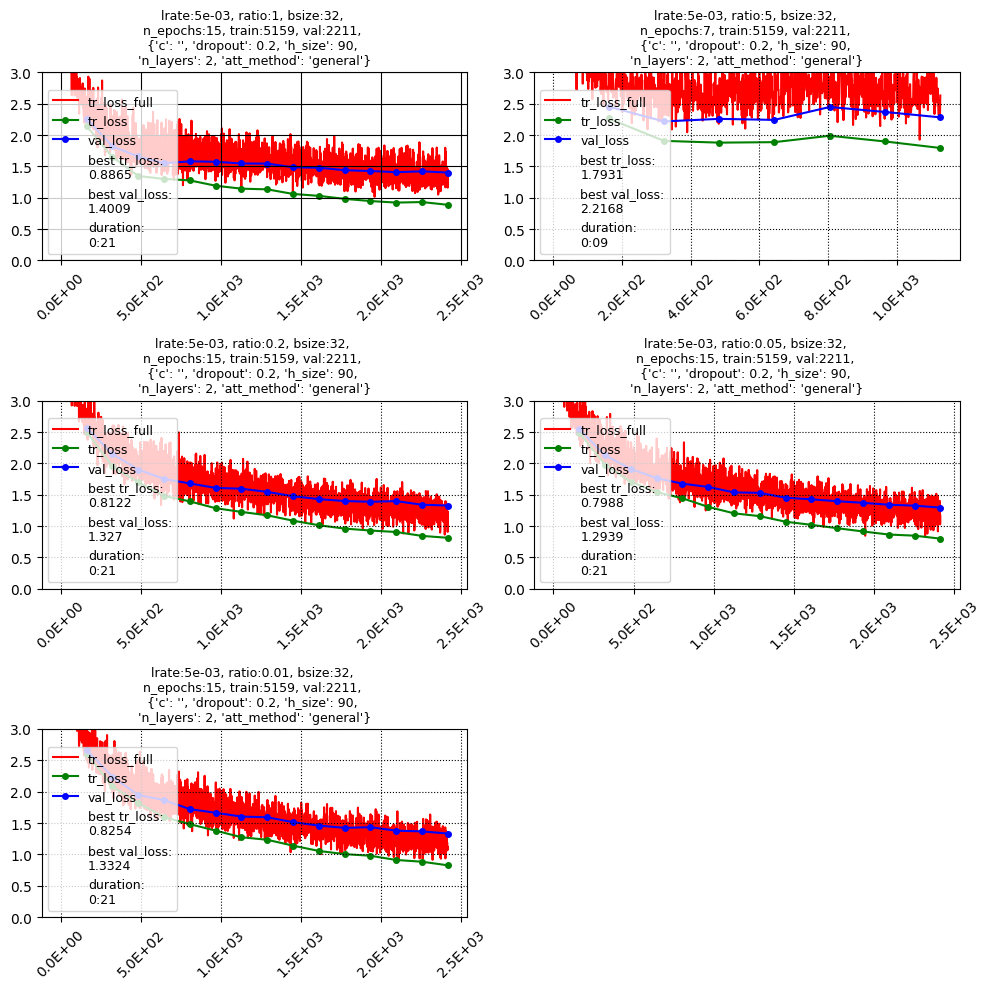

Duration: 1:36:32.520405
END ATLAS CALCULATION
Duration: 1:36:32.520457
21:52:48


In [27]:
# 

params = {     # put the longest before the shortest
    "lrate": [5e-3],  
    "dropout": [0.2],
    "ratio": [1, 5, 0.2, 0.05, 0.01],             
    "acc_steps": [2],          
    "bsize": [16],
    "h_size": [90],
    "n_layers": [2],
    "att_method": ['general']
}

keys = params.keys()
values = (params[key] for key in keys)
combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
start_time  = datetime.datetime.now()  
plt.style.use('default')
count = 1                   
                    ###### widath, depth of the plotting canvas
rcParams['figure.figsize'] = 10, 10

for i in combinations:        
        #print("Count: "+str(count))
        print("Count: "+str(count), file = terminal_output)

                    #rows, columns####
        plt.subplot(3, 2, count)                                                                           
        run_model(train_dataset, val_dataset, Luong_full, lossmaker1, device = device, 
                  bsize_eval = 64 , patience = 5, epochs = 15,
                  save = True, path = results_path, atlas = True,
                  vocab = input_lang.n_words, vocab_out = output_lang.n_words, c = "",
                  **i)
        count = count+1
        print("")
        
plt.tight_layout()
plt.show()

print('Duration: {}'.format(datetime.datetime.now() - start_time))    
print("END ATLAS CALCULATION", file=terminal_output)
print('Duration: {}'.format(datetime.datetime.now() - start_time), file=terminal_output)    
print(datetime.datetime.now().strftime("%H:%M:%S"), file=terminal_output)

21:52:48  Starting epoch 0
21:53:53  Calculating figures
21:54:10  Ending epoch 0    train_loss: 2.48   val_loss: 2.55
21:54:10  Starting epoch 1
21:55:16  Calculating figures
21:55:33  Ending epoch 1    train_loss: 2.0   val_loss: 2.14
21:55:33  Starting epoch 2
21:56:38  Calculating figures
21:56:56  Ending epoch 2    train_loss: 1.78   val_loss: 1.92
21:56:56  Starting epoch 3
21:58:02  Calculating figures
21:58:20  Ending epoch 3    train_loss: 1.59   val_loss: 1.81
21:58:20  Starting epoch 4
21:59:26  Calculating figures
21:59:44  Ending epoch 4    train_loss: 1.48   val_loss: 1.73
21:59:44  Starting epoch 5
22:00:53  Calculating figures
22:01:12  Ending epoch 5    train_loss: 1.37   val_loss: 1.68
22:01:12  Starting epoch 6
22:02:20  Calculating figures
22:02:39  Ending epoch 6    train_loss: 1.31   val_loss: 1.64
22:02:39  Starting epoch 7
22:03:47  Calculating figures
22:04:06  Ending epoch 7    train_loss: 1.24   val_loss: 1.61
22:04:06  Starting epoch 8
22:05:17  Calculating 

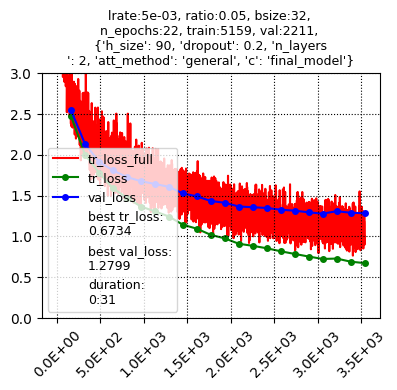

In [28]:
# 
outputs = run_model(train_dataset, val_dataset, Luong_full, lossmaker1, device= device, 
              lrate = 5e-3, ratio = 0.05, bsize = 16, acc_steps = 2, 
                                                    bsize_eval = 64, epochs = 25, patience = 3,
                    save = True, path = results_path, 
                  # the below are passed to the model class
                vocab = input_lang.n_words, h_size = 90, dropout = 0.2, n_layers = 2, 
                    att_method = 'general', vocab_out = output_lang.n_words,
                    c = "final_model"  
              )

In [29]:
1

1